# 

In [8]:
pip install --upgrade setuptools pip


Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


1.2 IMPORT DEPENDENCIES

In [1]:
#import dependencies
import cv2 #opencv
import os #abstracts OS 
import random #testing generating new data
import numpy as np #working with tensors
import matplotlib.pyplot as plt #display data as image visualization

In [2]:
# import tensorflow dependencies - functional API
from tensorflow.keras.models import Model #most imp for passing ip/op
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten #most imp class to create custom neural network Dense-gives vast dense network, maxpooling-creates a pool of networks, flatten-passes previous data and writes it in 1D
import tensorflow as tf

1.3 SET GPU GROWTH

In [3]:
#Avoid memory errors by setting GPU memory consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

1.4 CREATE FOLDER STRUCTURES

In [4]:

# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

2. COLLECT POSITIVE ANCHORS

2.1 COLLECT NEGATIVE IAMGES TO NEGATIVE FOLDER

In [6]:
#DOWNLOAD #http://vis-www.cs.umass.edu/lfw/#download
#uncompress Tar GZ labelled faces in wild dataset
!tar -xf lfw.tgz

tar: Error opening archive: Failed to open 'lfw.tgz'


In [7]:
#Move lfw images to the foll repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)


2.2 COLLECT POSITIVE AND ANCHOR CLASSES

In [8]:
#Import uuid library to generate unique image nmaes(gives specific file to generate identifiers)
import uuid

In [9]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))


'data\\anchor\\6cc4c20c-f1d3-11ee-bbb0-e99a9ccb9d5d.jpg'

In [10]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

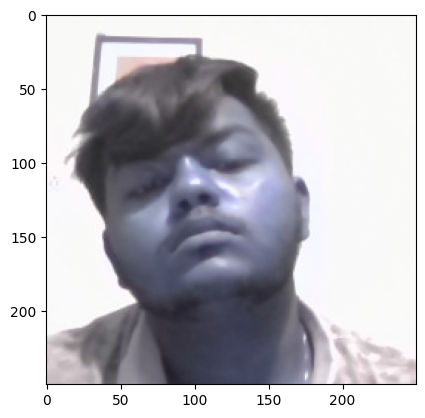

In [11]:
plt.imshow(frame)

3. LOAD AND PREPROCESS IMAGES

3.1 GET IMAGE DIRECTORIES

In [13]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [14]:
dir_test = anchor.as_numpy_iterator()

In [15]:
print(dir_test.next())

b'data\\anchor\\c8b48771-edea-11ee-9245-90211fab7b53.jpg'


3.2 PREPROCESSING SCALE AND RESIZE

In [16]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [17]:
img = preprocess('data\\anchor\\404119d8-ede8-11ee-b86f-90211fab7b53.jpg')

In [18]:
img.numpy().max() 

1.0

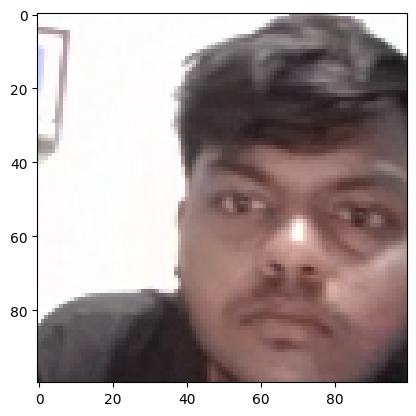

In [19]:
plt.imshow(img)

In [20]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

3.3 Create labelled Dataset

In [21]:
#(anchor,positive) => 1,1,1,1,1
#(anchor,negative) => 0,0,0,0,0

In [22]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [23]:
samples = data.as_numpy_iterator()

In [24]:
exampple = samples.next()

In [25]:
exampple

(b'data\\anchor\\c290ffd9-edea-11ee-8d38-90211fab7b53.jpg',
 b'data\\positive\\f8c04f49-edea-11ee-885c-90211fab7b53.jpg',
 1.0)

3.4 Build Train and Test Partition

In [26]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [27]:
res = preprocess_twin(*exampple)

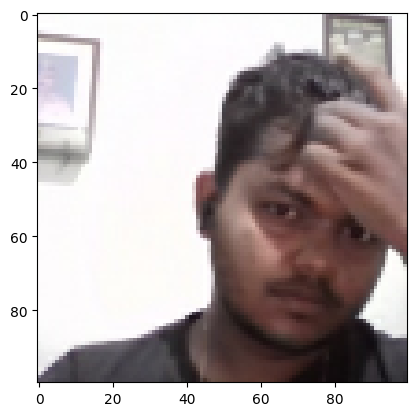

In [28]:
plt.imshow(res[1])

In [29]:
res[2]

1.0

In [30]:
#build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [31]:
#training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)


In [32]:
#testing partition 
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

4. MODEL ENGINEERIN

4.1 Build embedding layer

In [33]:
 inp = Input(shape=(100,100,3), name='input image')


In [34]:
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [35]:
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [36]:
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3) 

In [37]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [38]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [39]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [40]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [41]:
embedding = make_embedding()

In [42]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

4.2 Build distance layer

In [43]:
# build custom neural network
#Li method class
class L1Dist(Layer):

    #init method - inheritence
    def __init__(self, **kwargs): 
        super().__init__()

    #magic happens - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [44]:
l1 = L1Dist()

In [45]:
l1

4.3 make siamese model

In [46]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [47]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [48]:
siamese_layer = L1Dist()

In [49]:
distances = siamese_layer(inp_embedding, val_embedding)

In [50]:
classifier = Dense(1, activation='sigmoid')(distances)

In [51]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [52]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='siameseNetwork')

In [53]:
siamese_network.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [54]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [55]:
siamese_model = make_siamese_model()

In [56]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

5. TRAINING

5.1 Setup loss and optimizer

In [57]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [58]:
opt = tf.keras.optimizers.Adam(1e-4) #0.001

5.2 Establish checkpoints

In [59]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

5.3 Build Train step function

In [60]:
test_batch = train_data.as_numpy_iterator()

In [61]:
batch_1 = test_batch.next()

In [62]:
x = batch_1[:2]

In [63]:
y = batch_1[2]

In [64]:
y

array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
      dtype=float32)

In [65]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
      floating-point value which either represents a
      [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
      when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
      `from_logits=False`).

    **Recommended Usage:** (set `from_logits=True`)

    With `tf.keras` API:

    ```python
    model.compile(
      loss=tf.keras.losses

In [66]:

@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [67]:
5.4 Build training loop

SyntaxError: invalid syntax (3699496185.py, line 1)

In [68]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [69]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

5.5 Train the model

In [70]:
EPOCHS = 50

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
 3/27 [==>...........................] - ETA: 21:19

In [ ]:
6. EVALUATE MODEL

In [ ]:
6.1 Import metrics

In [71]:
#iMPORT METRIC CALCULATION
from tensorflow.keras.metrics import Precision, Recall

6.2 Make Predictions

In [72]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [73]:
y_true

array([0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0.],
      dtype=float32)

In [74]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 4s 4s/step


array([[0.49826005],
       [0.499652  ],
       [0.4997104 ],
       [0.4991117 ],
       [0.49917564],
       [0.49918446],
       [0.50030696],
       [0.499165  ],
       [0.49903566],
       [0.4998948 ],
       [0.4999846 ],
       [0.49964598],
       [0.49916416],
       [0.49969766],
       [0.49920362],
       [0.49941713]], dtype=float32)

In [77]:
#Post Processing the results
[ 1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [78]:
y_true

array([0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0.],
      dtype=float32)

In [79]:
6.3 calculate matrics

SyntaxError: invalid syntax (1375079054.py, line 1)

In [80]:
#creating a matric object
m = Precision()

#Calculate the recall value
m.update_state(y_true, y_hat)

#REturn results
m.result().numpy()

1.0

In [81]:
#creating a matric object
m = Recall()

#Calculate the recall value
m.update_state(y_true, y_hat)

#REturn results
m.result().numpy()

0.09090909

In [82]:
6.4 Visualize results 

SyntaxError: invalid syntax (3360903561.py, line 1)

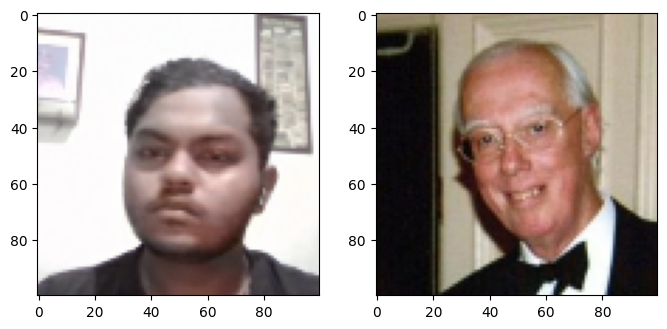

In [89]:
#set plot size (img)
plt.figure(figsize=(8,8))

# set first subplot no. of rows,columns,index
plt.subplot(1,2,1)
#change value of image in imput like 1st:img 2nd:img
plt.imshow(test_input[0])

#set second subplot
plt.subplot(1,2,2)
#change value of image in value like 1st:img 2nd:img  [[img of plot 1 and 2 should be same
plt.imshow(test_val[0])

#renders cleanly
plt.show()

7. SAVE THE MODEL

In [84]:
#save weights
siamese_model.save('siamesemodel.h5')

C:\Users\Atharva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [85]:
#reload model
model = tf.keras.models.load_model('siamesemodel.h5', 
                                  custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [86]:
#make predictions on reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 5s 5s/step


array([[0.49826005],
       [0.499652  ],
       [0.4997104 ],
       [0.4991117 ],
       [0.49917564],
       [0.49918446],
       [0.50030696],
       [0.499165  ],
       [0.49903566],
       [0.4998948 ],
       [0.4999846 ],
       [0.49964598],
       [0.49916416],
       [0.49969766],
       [0.49920362],
       [0.49941713]], dtype=float32)

In [90]:
# view model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

7. REAL TIME TEST

7.1 verification function

In [91]:
def verify(model, detection_threshold, verification_threshold):
    #build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_images', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        #Make predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection threshold: metrix above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # verification threshold: proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

   
    

7.2  OpenCV real time verification

In [92]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    cv2.imshow('Verification', frame)

    #verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #save input img to input_img folf\der
        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), frame)
        #run verification 
        results, verified = verify( model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
    

1/1 [==============================] - 0s 279ms/step
False
